In [1]:
# !pip install tensorflow==2.6.0
# !pip install Cython==0.29.24
# !pip install numpy==1.19.5
# !pip install matplotlib==3.2.2 
# !pip install seaborn==0.11.2 
# !pip install scipy==1.4.1 
# !pip install scikit-learn==0.22.2.post1 
# !pip install scikit-image==0.16.2 
# !pip install pandas==1.1.5 
# !pip install pyyaml 
# !pip install imutilstqdm==4.62.3 
# !pip install psutil==5.4.8 
# !pip install h5py==3.1.0

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

%matplotlib inline

In [3]:
onColab = True
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE2
  !ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/University/ANN/CHALLENGE2
analysis.ipynb
baseline
baseline_2
baseline_2_ckpt
baseline_3
baseline_3_ckpt
baseline_3_forSub
baseline_3_training_smooth
baseline_3_training_smooth_ckpt
baseline_4
baseline_4_ckpt
baseline_5
baseline_5_ckpt
baseline_ckpt
baseline.ipynb
d2ee2_ERR_smooth_training.ipynb
d2ee2_smooth_training.ipynb
d2ee2_tl_with_weigths_smooth_training.ipynb
err_7.csv
inno_training_fft_1
inno_training_lowpass_1
inno_training_smooth
inno_training_smooth_2
inno_training_smooth_3
inno_training_smooth_4
inno_training_smooth_4_1
inno_training_smooth_5
inno_training_smooth_6
inno_training_smooth_7
inno_training_smooth_7_ERR
inno_training_tl_weights_4
inno_training_weights_4
model.png
multimodel_1
multimodel_2
multi_model_2.ipynb
multi_model.ipynb
multimodel_model.ipynb
multimodel_with_baseline
multimodel_with_baseline_2
multimodel_with_baseline_3
my_net
my

In [4]:
#@title init seed everywhere
seed =20
import random
import os

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
dataset = pd.read_csv('./Training.csv')

In [6]:
def chunk(x, size, stride):
  """
  divide the dataset in chunks. It keeps the right-most elements and discard the left ones, if size and stride are not
  compatible with dimensions
  """
  ret = []
  for i in range(len(x) - size, -1, -stride):
    ret.append([[j] for j in x[i: i + size]])
  ret.reverse()
  return np.array(ret)
  ## allignment is on the RIGHT

def getInpToNet(dataset, size, stride):
  ret = None
  for i in dataset:
    if ret is None:
      ret = chunk(dataset[i], size, stride)
      print(ret.shape)
    else:
      ret = np.concatenate((ret, chunk(dataset[i], size, stride)), axis=-1)
      print(ret.shape)
  return ret

size = 512
stride = 10

k = getInpToNet(dataset, size, stride)

(6802, 512, 1)
(6802, 512, 2)
(6802, 512, 3)
(6802, 512, 4)
(6802, 512, 5)
(6802, 512, 6)
(6802, 512, 7)


In [7]:
def rebuild(y, size, stride):
  """
  rebuild the original (if no cut were made) after the chunk function
  """
  s = size - stride
  ret = [0 for i in range(len(y[0]) * len(y) - (s * (len(y) - 1)))]

  for i in range(len(y[0])):
      ret[i] = y[0][i]

  ind = size
  for i in y[1:]:
    l = s
    for j in i:
      if l > 0:
        ret[ind - l] = (ret[ind - l] + j) / 2
      else:
        ret[ind - l] = j
      l -= 1
    ind += size - s
  return ret

# # test
# x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# size = 4
# stride = 3
# print(rebuild(chunk(x, size, stride), size, stride))
# assert rebuild(chunk(x, size, stride), size, stride) == x

# x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# size = 4
# stride = 2
# print(rebuild(chunk(x, size, stride), size, stride))
# assert rebuild(chunk(x, size, stride), size, stride) == x

In [8]:
input_shape = (size, 7)

input = tfk.Input(shape=input_shape)
encoded = tfkl.Reshape((input_shape[0] * input_shape[1],))(input)
encoded = tfkl.Dense(2048, activation='selu')(encoded)
encoded = tfkl.Dense(1024, activation='selu')(encoded)
encoded = tfkl.Dense(512, activation='selu')(encoded)

decoded = tfkl.Dense(1024, activation='selu')(encoded)
decoded = tfkl.Dense(2048, activation='selu')(decoded)
decoded = tfkl.Dense(input_shape[0] * input_shape[1], activation='selu')(decoded)
decoded = tfkl.Reshape(input_shape)(decoded)

autoencoder = tfk.Model(input, decoded)
autoencoder.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

In [9]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 7)]          0         
                                                                 
 reshape (Reshape)           (None, 3584)              0         
                                                                 
 dense (Dense)               (None, 2048)              7342080   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 dense_4 (Dense)             (None, 2048)              209920

In [10]:
batch_size = 128
# Train the model
history = autoencoder.fit(
    x = k,
    y = k,
    batch_size = batch_size,
    epochs = 400,
    validation_split = 0.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5),
    ]
).history

Epoch 1/400
48/48 [==============================] - 2s 30ms/step - loss: 107.3019 - mae: 5.4945 - val_loss: 34.3563 - val_mae: 3.6078 - lr: 0.0010
Epoch 2/400
48/48 [==============================] - 1s 21ms/step - loss: 19.0053 - mae: 2.7404 - val_loss: 30.4219 - val_mae: 3.1335 - lr: 0.0010
Epoch 3/400
48/48 [==============================] - 1s 22ms/step - loss: 17.2396 - mae: 2.5031 - val_loss: 29.6951 - val_mae: 3.0343 - lr: 0.0010
Epoch 4/400
48/48 [==============================] - 1s 21ms/step - loss: 16.2527 - mae: 2.3624 - val_loss: 29.3016 - val_mae: 2.9917 - lr: 0.0010
Epoch 5/400
48/48 [==============================] - 1s 22ms/step - loss: 15.7345 - mae: 2.2970 - val_loss: 28.5090 - val_mae: 2.8842 - lr: 0.0010
Epoch 6/400
48/48 [==============================] - 1s 21ms/step - loss: 15.8639 - mae: 2.3376 - val_loss: 28.7152 - val_mae: 2.9486 - lr: 0.0010
Epoch 7/400
48/48 [==============================] - 1s 21ms/step - loss: 14.7828 - mae: 2.2102 - val_loss: 27.1745 -

In [12]:
autoencoder.save('autoencoder_1_512')

INFO:tensorflow:Assets written to: autoencoder_1_512/assets


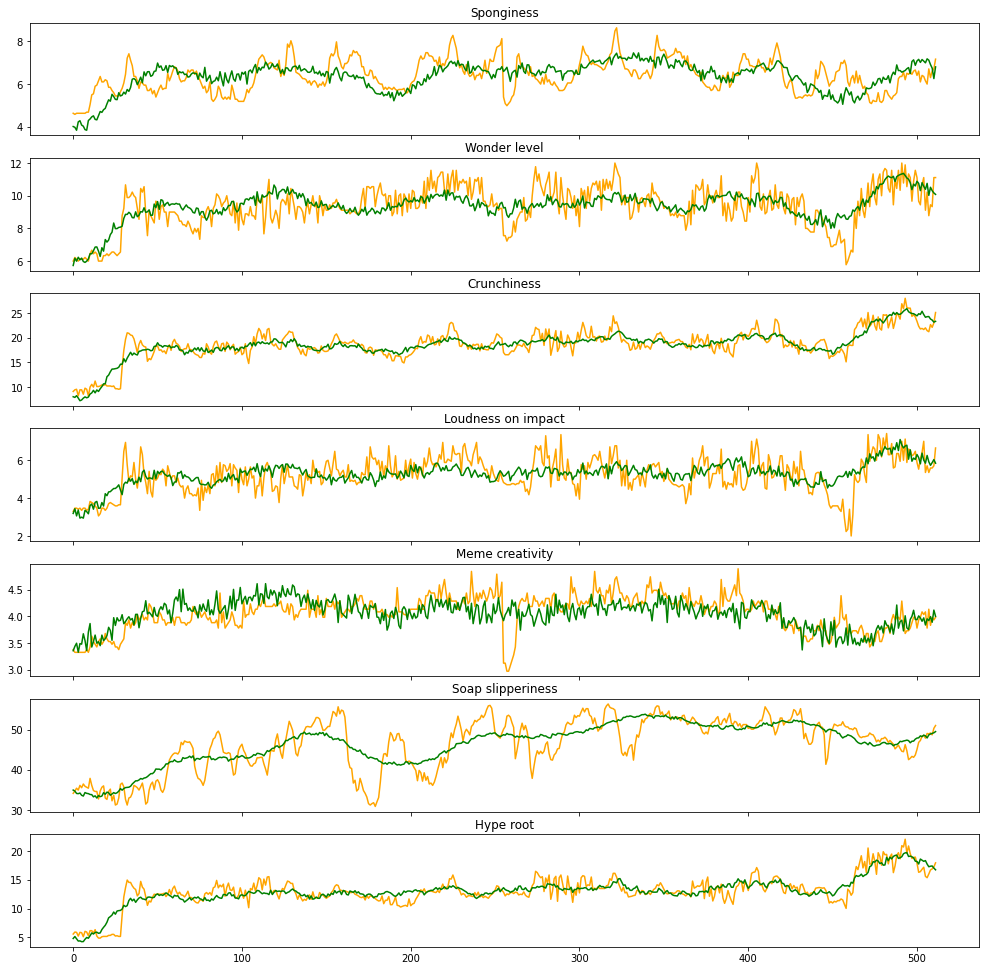

In [13]:
def inspect_multivariate_prediction(X, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i])), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        # axs[i].set_ylim(0,1)
    plt.show()
inspect_multivariate_prediction(np.array([k[10]]), autoencoder.predict(np.array([k[10]])), dataset.columns, len(k[10]))

In [14]:
stride = size
ds_chunked = getInpToNet(dataset, size, stride)

(133, 512, 1)
(133, 512, 2)
(133, 512, 3)
(133, 512, 4)
(133, 512, 5)
(133, 512, 6)
(133, 512, 7)


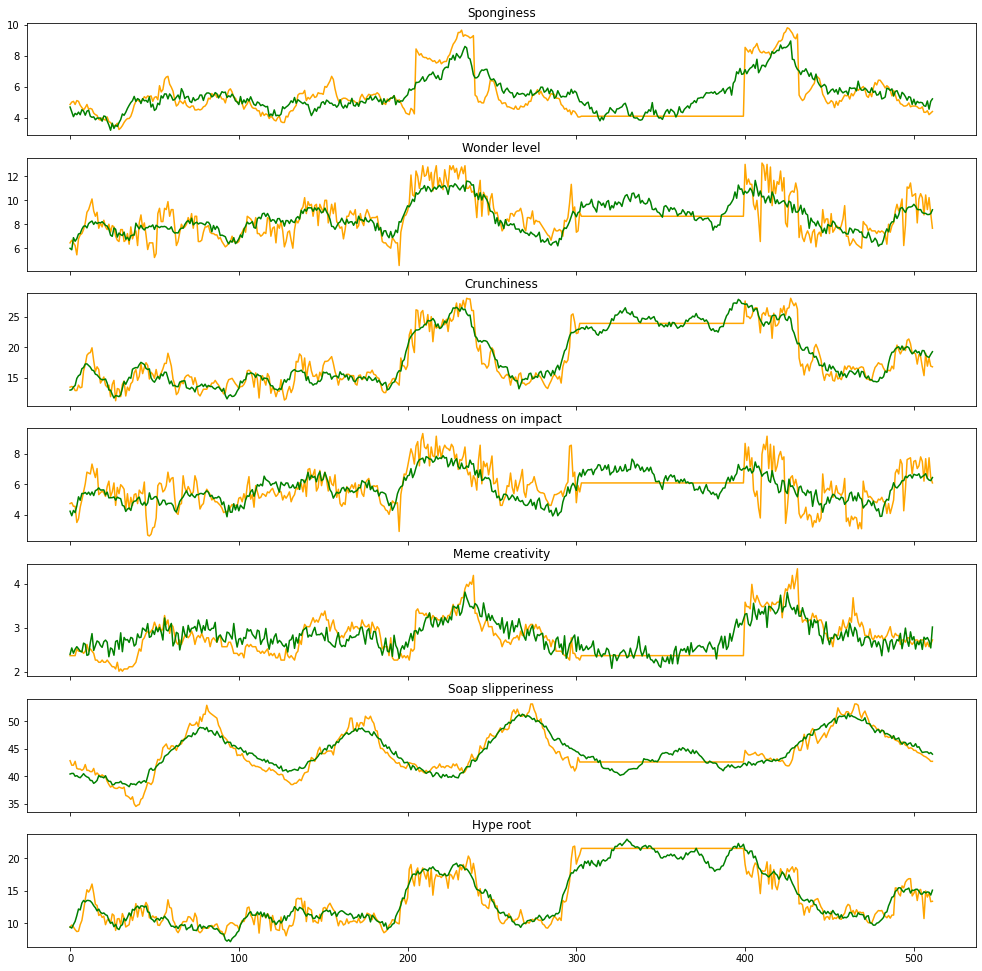

In [40]:
inspect_multivariate_prediction(np.array([ds_chunked[10]]), autoencoder.predict(np.array([ds_chunked[10]])), dataset.columns, len(k[10]))

In [15]:
ds_predicted = autoencoder.predict(ds_chunked)

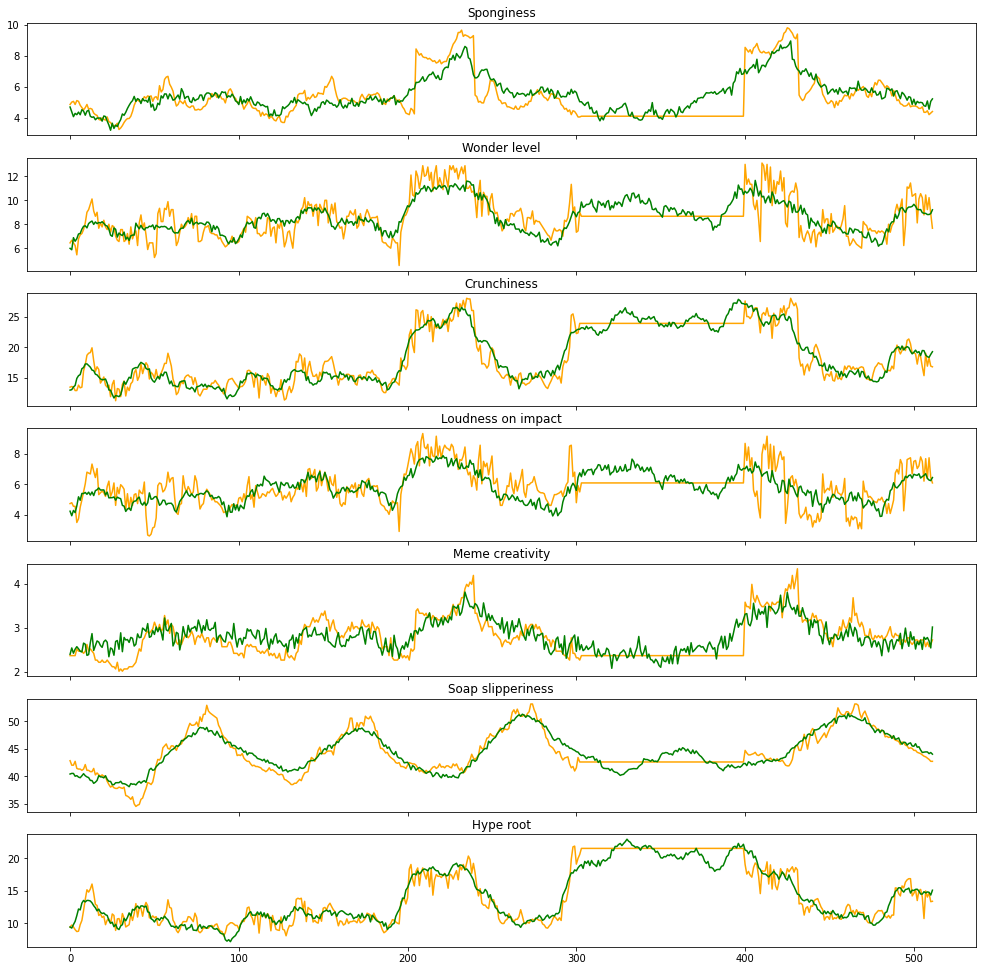

In [41]:
inspect_multivariate_prediction(np.array([ds_chunked[10]]), np.array([ds_predicted[10]]), dataset.columns, len(k[10]))

In [54]:
new_ds = np.array(rebuild(ds_predicted, size, stride))

In [55]:
new_ds.shape
new_df = pd.DataFrame(new_ds, columns=dataset.columns)

In [56]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(new_ds, dataset[len(dataset)-len(new_df):])
print(mse)

10.152560100574258


In [57]:
def visualize(x, r, inf=40, sup=400):
  discarded = len(x) - np.array(r).shape[0] 
  print("we discarded ", discarded, "initial points")
  x_ax = np.arange(sup - inf)
  plt.figure(figsize=(10, 6))
  plt.scatter(x_ax, x[inf + discarded:sup + discarded])
  plt.plot(x_ax, r[inf:sup], c='red')
  plt.show()

we discarded  432 initial points


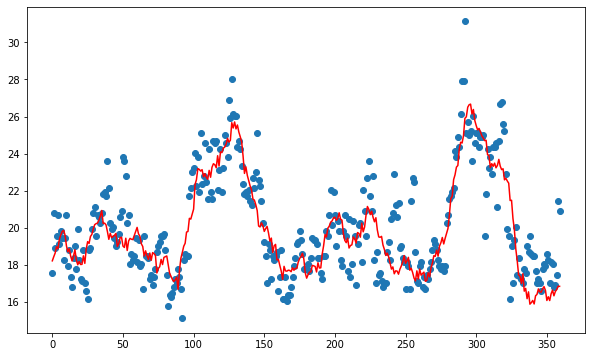

In [60]:
visualize(dataset['Crunchiness'], new_df['Crunchiness'])

In [61]:
save = True
if save:
  new_df.to_csv('Training_autoencoder1.csv', index=False)